Let's look at what we expect DCR to look like.  By default, MAF will generate DCR offsets per filter like:  {'u': 0.07, 'g': 0.07, 'r': 0.050, 'i': 0.045, 'z': 0.042, 'y': 0.04}

where the units on that are arcseconds. So, we get up to 0.7" of DCR offset in g. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
dbFile = 'baseline_v1.4_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
sql = 'filter="g"'
metric = metrics.PassMetric(cols=['ra_dcr_amp', 'dec_dcr_amp', 'PA', 'airmass', 'zenithDistance'])
slicer = slicers.UserPointsSlicer(ra=[0.], dec=[-25.])
plotDict = {'colorMax': 27.4}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict))

In [4]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()


Querying database SummaryAllProps with constraint filter="g" for columns ['fieldRA', 'observationStartLST', 'altitude', 'fieldDec', 'observationStartMJD', 'airmass', 'filter']
Found 209798 visits
Running:  ['opsim_Pass_ra_dcr_amp_dec_dcr_amp_PA_airmass_zenithDistance_g_USER']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:127: UserWarning: Warning - column PA already present in simData, may be overwritten (depending on stacker).
  % (col))
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:127: UserWarning: Warning - column HA already present in simData, may be overwritten (depending on stacker).
  % (col))
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:127: UserWarning: Warning - column zenithDistance already present in simData, may be overwritten (depending on stacker).
  % (col))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [6]:
mv = bundleList[0].metricValues[0]
mv.size

77

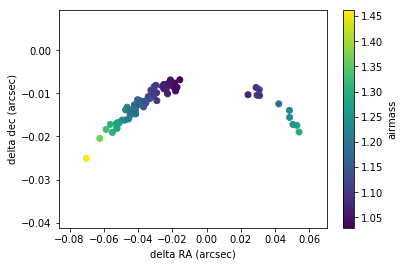

In [9]:
plt.scatter(mv['ra_dcr_amp'], mv['dec_dcr_amp'], c=mv['airmass'])
plt.xlabel('delta RA (arcsec)')
plt.ylabel('delta dec (arcsec)')
cb = plt.colorbar()
cb.set_label('airmass')

# Ah, the spread here is because it's computing it for the center of each pointing that overlaps this point. 

Text(0, 0.5, 'RA offset (arcsec)')

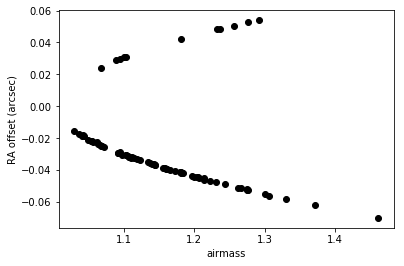

In [10]:
plt.plot(mv['airmass'],mv['ra_dcr_amp'],  'ko')
plt.xlabel('airmass')
plt.ylabel('RA offset (arcsec)')

Text(0, 0.5, 'dec offset (arcsec)')

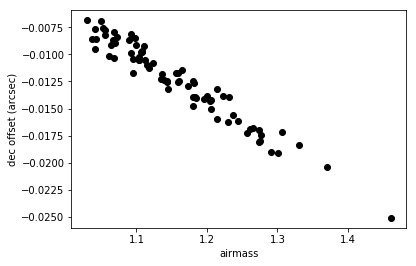

In [11]:
plt.plot(mv['airmass'],mv['dec_dcr_amp'],  'ko')
plt.xlabel('airmass')
plt.ylabel('dec offset (arcsec)')

Text(0, 0.5, 'RA offset (arcsec)')

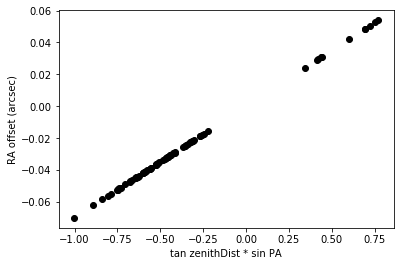

In [12]:
# So, I can make this a linear relationship like so
plt.plot(np.tan(np.radians(mv['zenithDistance']))*np.sin(np.radians(mv['PA'])), mv['ra_dcr_amp'], 'ko')
plt.xlabel('tan zenithDist * sin PA')
plt.ylabel('RA offset (arcsec)')

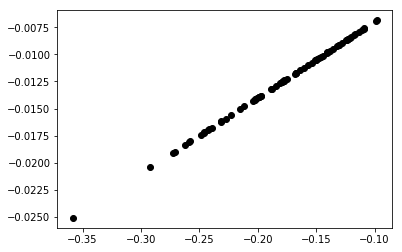

In [11]:
plt.plot(np.tan(np.radians(mv['zenithDistance']))*np.cos(np.radians(mv['PA'])), mv['dec_dcr_amp'], 'ko')

Now, I can say what the uncertainty in the y-axis is via the FWHM and 5-sigma depths. 

This is fitting a line constrained to go through 0,0.  

The better I constrain the slope of the line, the better I understand the DCR of the object. 

Ah, units here are a little weird, since tan(zd)sin(pa) is unitless, the slope has units of arsec/unitless. So, the slope is just the absolute value at +/- 1. 